<a href="https://colab.research.google.com/github/katherymbr/Dim_fractalMontecarlo_Sierpinskipinsk/blob/main/R4_Dim_fractal_Montecarlo_Mamografias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  DIMENSION DE HAUSDORFF O FRACTAL, USANDO EL MÉTODO MONTECARLO+ MAMOGRAFÍAS

# IMPLEMENTACIÓN DEL MÉTODO EN MAMOGRAFIAS

*  DIMENSION DE HAUSDORFF O FRACTAL

Despues de realizar la Calibración del metodo de dimensión fractal integrado con montecarlo, con el triangulo de selspinski, se procedio a calcular la dimension fractal bajo este metodo en mamografias con microcalcificaciones

*  Método  montecarlo

El método de Montecarlo se integrará al cálculo de la dimensión fractal. Para ello, se generarán puntos aleatorios dentro del viewport que cumplan con la distribución de Montecarlo, es decir, puntos que satisfagan
𝑥
2
+
𝑦
2
≤
𝑟
2
 , donde
𝑟
2
=
(
𝑙
/
2
)
2

  y
𝑙
l es el lado del viewport, el cual debe ser cuadrado. Posteriormente, en esos puntos que cumplen la distribución de Montecarlo, se ubica la imagen dentro del viewport y se cuenta el número de píxeles para 2 divisiones del Box Counting, 4 divisiones, 16 divisiones, y así sucesivamente. Este proceso se repite para cada posición generada por Montecarlo. Finalmente, se grafica la relación
log
⁡
(
1
/
boxes
)
vs.
log(N), donde la pendiente de la gráfica representa la dimensión fractal.


Nota: Es crucial tener precaución con los puntos de Montecarlo al posicionar la imagen dentro del viewport según la condición establecida. Se debe evitar o RESTRINGIR que los puntos queden en las fronteras del círculo de Montecarlo, ya que esto puede resultar en que la imagen se divida entre el interior y el exterior del círculo. Este fenómeno es evidente en la simulación.



```
# Proyecto 3 - Fractales
```

Autores: Katherym Bambague Ruíz, Ronny Guevara

*   Importo liberias

In [2]:
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, data, exposure
import math
import random
import pandas  as pd
import numpy as np
from scipy.stats import linregress

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# FUNCIONES

# 1.  F - DESCOMPONER IMAGEN EN SUS CANALES R,G,B

In [4]:
# FUNCIÓN PARA DESCOMPONER LA IMAGEN EN SUS CANALES R,G,B

def image_to_rgb(imagen):

  r = imagen[:,:,0]/255.0
  g = imagen[:,:,1]/255.0
  b = imagen[:,:,2]/255.0

  return r, g, b


# 2. F - PASAR DE RGB A YIQ

In [5]:
# FUNCIÓN PARA PASAR DE RGB A YIQ

def rgb_yiq (r1,g1,b1):

  y= 0.299*r1  +0.587*g1   +0.11*b1
  i= 0.596*r1  -0.274*g1   -0.322*b1
  q= 0.211*r1  -0.523*g1   +0.312*b1

  return(y,i,q)


#  3. F - UMBRAL OTSU - SIMPLE

In [6]:
# FUNCIÓN PARA CALCULAR EL UMBRAL DE OTSU

def Otsu(imagen):

  umbral_otsu= filters.threshold_otsu(imagen)
  # Calcular el histograma de la imagen
  hist, bins_center = exposure.histogram(imagen)

  # Graficar el histograma
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.bar(bins_center, hist, width=0.5, color='gray')
  plt.title('Histograma de la imagen')
  plt.xlabel('Intensidad de píxel')
  plt.ylabel('Frecuencia')

  # Graficar el umbral de Otsu
  plt.axvline(umbral_otsu, color='r', linestyle='--', linewidth=2, label='Umbral de Otsu')
  plt.legend()

  # Mostrar la imagen original y aplicar el umbral de Otsu
  plt.subplot(122)
  plt.imshow(imagen, cmap='gray')
  plt.title('Imagen con umbral de Otsu')
  plt.axhline(umbral_otsu, color='r',linestyle='--', linewidth=0.01)
  plt.axis('off')
  plt.show()

  return umbral_otsu


# 4. F -  BINARIZAR UNA IMÁGEN

In [7]:
# FUNCIÓN PARA BINARIZAR UNA IMAGÉN

def binarizacion(img_norm, umbral):

  im_binary1 = np.copy(img_norm)

  mask_1 = im_binary1 >=  umbral  # umbral_otsu
  mask_2 = im_binary1 <  umbral   # umbral_otsu

  im_binary1[mask_1] = 1 # pixeles mayores, igualeses a umbral_otsu: toman tomar el valor de 1
  im_binary1[mask_2] = 0 # pixeles menores a umbral_otsu: toman tomar el valor de 0

  print(im_binary1.shape)
  print("pixel minimo:",im_binary1.max())
  print("pixel máximo:",im_binary1.min())

  return im_binary1


# 5. F - VIEWPORT CUADRADO Y PUNTOS MONTECARLO

In [9]:
# FUNCIÓN QUE GENERA EL VIEWPORT CUADRADO A PARTIR DE UNA IMAGEN DE ENTRADA Y UN FACTOR BETA

def viewport_cuadrado(img, beta):
    "beta es el Factor de incremento del viewport con respecto a las dimensiones de la imagen"
    # Definición del área del viewport
    viewport_y, viewport_x = img.shape
    print("--------------------------------------")
    print("Dimensiones de la imagen de entrada a la función - viewport cuadrado-:", img.shape)
    # Ajustar las dimensiones para que el viewport sea cuadrado
    max_dimension = max(viewport_y, viewport_x)
    print("--------------------------------------")
    print("Se tomará el lado mas grande de la imagen de entrada, para formar el cuadrado:", max_dimension)
    # Ajustar las dimensiones dado el factor beta
    max_dimension = int(max_dimension * beta)
    print("--------------------------------------")
    print("El factor de incremento de la iamgen sera un factor Beta: ", beta)
    # Crear un viewport cuadrado
    viewport = np.zeros((max_dimension,  max_dimension))
    print("--------------------------------------")
    print("Dimensiones del viewport: {}".format(viewport.shape))
    print("--------------------------------------")
    return  viewport

# FUNCIÓN PARA DIBUJAR UN CIRCULO ENCIMA DE CUALQUIER IMAGEN DE ENTRADA "cuadrada". Donde el radio del circulo es la mitad del larfo de la imagen

def generar_circulo(img):
    # Obtiene las dimensiones de la imagen
    alto_y, ancho_x = img.shape[:2]
    # Calcula el centro de la imagen
    centro_x = ancho_x / 2
    centro_y = alto_y / 2
    print("++++++++++++++++++++++++++++++++++++++")
    print("El radio del circulo dibujado es:", centro_x)
    print("++++++++++++++++++++++++++++++++++++++")
    # genera el círculo dado el centro
    circulo = plt.Circle((centro_x, centro_y), ancho_x / 2, color='blue', fill=False)
    return circulo

# Función para verificar si un punto cumple con la condición de MONTECARLO
def verificar_condicion(x, y, ancho_x):
    return x ** 2 + y ** 2 <= (ancho_x / 2) ** 2

# FUNCION PARA GENERAR PUNTOS MONTECARLO
def generar_puntos_montecarlo(img, num_puntos):
    print("El total de puntos aleatorios a evaluar es: ", num_puntos)
    print(".....................................")
    puntos_cumplen_condicion = []
    alto_y, ancho_x = img.shape[:2]
    # Definir el número de puntos a generar
    for i in range(num_puntos):
        # Generar coordenadas (x, y) dentro del rango especificado
        x = random.uniform(0, ancho_x)
        y = random.uniform(0, alto_y)

        # Verificar si el punto cumple con la condición
        if verificar_condicion(x - ancho_x / 2, y - alto_y / 2, ancho_x):
            puntos_cumplen_condicion.append((x, y))
    print("los puntos que cumplen la condición de montecarlo sin importar la frontera:",puntos_cumplen_condicion)
    return puntos_cumplen_condicion

#FUNCIÓN PARA VERIFICAR SI LOS 4 PUNTOS DE LA IMAGEN QUE SE INDEXA CUMPLE CON LA CONDICION DE MONTECARLO
# Y NO SE SALEN DEL CIRCULO

def verificar_im_en_circulo(x, y, im, viewport):

    l_view = viewport.shape[0]
    y_im, x_im = im.shape
    x_real = x - l_view/2
    y_real = y - l_view/2
    x_val = None
    y_val = None

    # Verificar que la imagen no se sale del rango del circulo en ninguno de los cuadrantes
    if (verificar_condicion(y_real,        x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real + x_im, l_view) and
        verificar_condicion(y_real,        x_real + x_im, l_view)):
      x_val, y_val = x, y
    return x_val, y_val


# 6. F - BOX COUNTING

In [10]:
# **************************** Box counting ***********************************************

# Invoco la función: def box_counting2(img, viewport, x_val, y_val)
# viewport debe ser cuadrado

def box_counting2(img, viewport, x_val, y_val):

    y_im, x_im = img.shape
    viewport[y_val:y_val+y_im, x_val:x_val+x_im] = img

    viewport_y, viewport_x = viewport.shape

    # Obtengo la dimensión mínima del viewport (ahora cuadrado)
    min_axes = min(viewport.shape)

    # Obtener la mayor potencia de 2 que sea menor al valor de min_axes
    nbase = 2 ** np.floor(np.log(min_axes) / np.log(2))

    # Se obtiene el exponente
    n = int(np.log(nbase) / np.log(2))

    #se obtiene el tamaño de los boxes
    # Se obtienen los boxes (media) en base 2^n  hasta 2^1
    boxes = 2 ** np.arange(1, n + 1, 1)[::-1]


    # Contar los pixeles en cada box para cada partición 2^n
    # Considerando el tamaño de los boxes se cuentan los pixeles que hay en cada box, para cada partición 2^n
    counts = []
    for box in boxes:
        bc = np.add.reduceat(
            np.add.reduceat(viewport, np.arange(0, viewport_y, box), axis=0),
            np.arange(0, viewport_x, box), axis=1)
        # Se cuentan el número de box cuya suma de pixels sea mayor a 0 y menor box^2
        counts.append(len(np.where((bc > 0) & (bc < box ** 2))[0]))

    log_inv_boxes_X = np.log(1 / boxes)
    log_counts_y = np.log(counts)
    #print(log_counts_y )


    return log_inv_boxes_X[::-1], log_counts_y[::-1]


EJECUCUIÓN

(336, 287, 4)
pixel minimo: 255
pixel máximo: 1


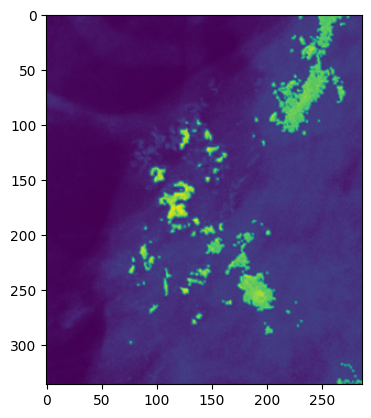

In [52]:
# Leo la imagen,imprimo su tamaño y la visualizo

imagen1=io.imread('/content/drive/MyDrive/final_procesamiento.png')

plt.imshow(imagen1, cmap='gray')

print(imagen1.shape)
print("pixel minimo:",imagen1.max())
print("pixel máximo:",imagen1.min())


In [53]:
# Descompongo la imagen en R, G, B

r1,g1,b1= image_to_rgb(imagen1)


(336, 287)
pixel minimo: 0.8439372549019607
pixel máximo: 0.11827058823529411


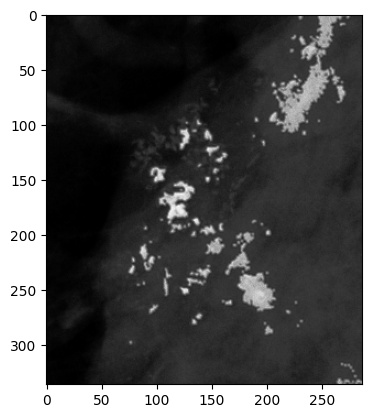

In [54]:
# Paso la imagen del espacio RGB al espacio YIQ. Tomo las luminancias Y.

y1,i1,q1= rgb_yiq (r1,g1,b1)
print(y1.shape)
print("pixel minimo:",y1.max())
print("pixel máximo:",y1.min())
plt.imshow( y1, cmap='gray')


In [55]:
# Normalizo la imagen que está en el espacio de luminancias (Y)

#normalizo la imagen y la llevo a la escala de 0 a 1
imagen1_copy_norm=(y1 - y1.min()) / (y1.max() - y1.min())
print(imagen1_copy_norm.shape)
print("pixel minimo:",imagen1_copy_norm.max())
print("pixel máximo:",imagen1_copy_norm.min())


(336, 287)
pixel minimo: 1.0
pixel máximo: 0.0


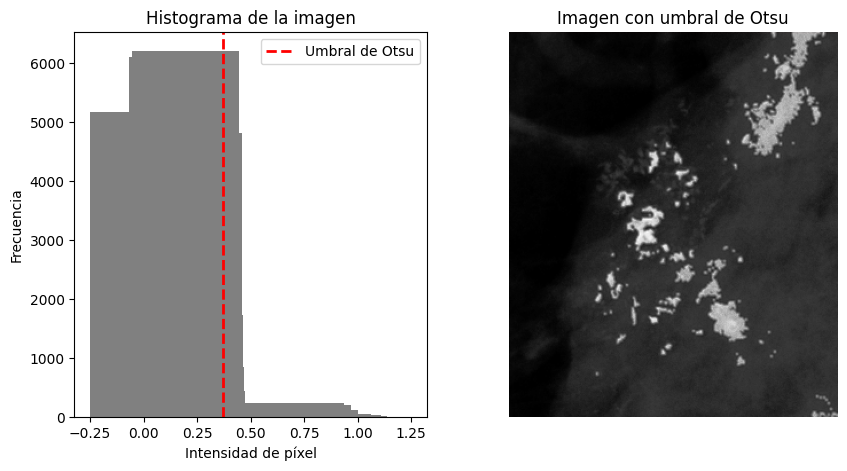

EL UMBRAL DE OTSU ES: 0.373046875


In [58]:
# Aplico la función para encontrar el Umbral de Otsu  en imagenes normaizadas entre 0 y 1. Después grafico

umbral_otsu = Otsu(imagen1_copy_norm)
print("EL UMBRAL DE OTSU ES:",umbral_otsu)


BINARIZACIÓN: Se binariza la imagen usando el umbral de Otsu obtenido anteriormente

(336, 287)
pixel minimo: 1.0
pixel máximo: 0.0


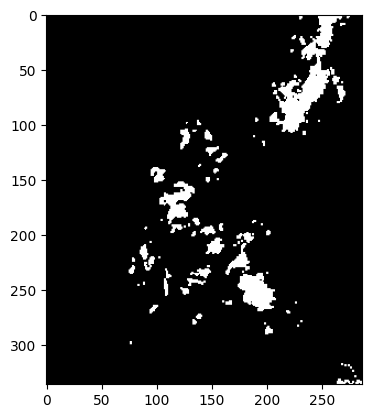

In [59]:
# Binarizo la imagen usando el umbral de OTSU y la función para binarizar

img_binarizada= binarizacion(imagen1_copy_norm,  umbral_otsu)
plt.imshow(img_binarizada, cmap='gray')


## INVOCO LAS FUNCIONES PARA VIERPORT CUADRADO Y MONTECARLO

In [63]:
# Uso las funciones que estan en. 5.VIEWPORT CUADRADO Y PUNTOS MONTECARLO

# Invoco:  def viewport_cuadrado(img, beta):
view_cuadrado = viewport_cuadrado(img_binarizada, beta=5)

# Invoco: def generar_circulo(img):
circulo = generar_circulo(view_cuadrado)


# Invoco: def generar_puntos_montecarlo(img, num_puntos=50):
puntos_montecarlo = generar_puntos_montecarlo(view_cuadrado, num_puntos=50) #*****////////////aqui cambio el nro de puntos

# Verifico que haya puntos generados, no esten en la frontera y se puedan dibujar dentro del circulo sin que qeude algo por fuera
if puntos_montecarlo:
    x_dentro, y_dentro = zip(*puntos_montecarlo)
    x_val_list = []
    y_val_list = []
    for punto in range(len(x_dentro)):
      # Invoco: def verificar_im_en_circulo(x, y, im, viewport):
      # Verifico que los puntos se puedan dibujar y no esten en la frontera del circulo montecarlo
      # Se evaluan los 4 puntos de la imagen
      x_val, y_val = verificar_im_en_circulo(x_dentro[punto], y_dentro[punto], img_binarizada, view_cuadrado)
      if x_val:
        x_val_list.append(x_val)
        y_val_list.append(y_val)

    print('Número total de puntos que cumplen la condición MONTECARLO: ', len(x_dentro))
    print("*************************************")
    # Puntos que no estan en la frontera del circulo MOntecarlo y SI se pueden dibujar
    print('Número de puntos que cumplen MONTECARLO y SI se pueden dibujar: ', len(x_val_list))
    print("puntos a dibujar en x:", x_val_list )
    print("puntos a dibujar en y:", y_val_list )
    print("*************************************")



--------------------------------------
Dimensiones de la imagen de entrada a la función - viewport cuadrado-: (336, 287)
--------------------------------------
Se tomará el lado mas grande de la imagen de entrada, para formar el cuadrado: 336
--------------------------------------
El factor de incremento de la iamgen sera un factor Beta:  5
--------------------------------------
Dimensiones del viewport: (1680, 1680)
--------------------------------------
++++++++++++++++++++++++++++++++++++++
El radio del circulo dibujado es: 840.0
++++++++++++++++++++++++++++++++++++++
El total de puntos aleatorios a evaluar es:  50
.....................................
los puntos que cumplen la condición de montecarlo sin importar la frontera: [(613.832816982658, 1160.5844149236182), (1583.194820596577, 760.5201345236121), (1021.310423154951, 581.2122601021185), (641.3411353727327, 459.71620015102263), (1404.6137977969397, 302.05312633181916), (1123.1273582791164, 1623.1570215184497), (516.157339222

## Visualizar solo viewport y puntos

In [20]:
"""
plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro
plt.scatter(x_dentro, y_dentro, color='red')
plt.scatter(x_val_list, y_val_list, color='green')
plt.gca().add_artist(circulo)
"""

"\nplt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro\nplt.scatter(x_dentro, y_dentro, color='red')\nplt.scatter(x_val_list, y_val_list, color='green')\nplt.gca().add_artist(circulo)\n"

## Visualizar viewport, putos y la imagen en todas las posiciones validas

In [ ]:
"""
for puntos in range(len(x_val_list)):
  x_d, y_d = int(x_val_list[puntos]), int(y_val_list[puntos])
  y_im, x_im = img_binarizada.shape
  view_cuadrado[y_d:y_d+y_im, x_d:x_d+x_im] = img_binarizada
  plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro
  #plt.scatter(x_dentro, y_dentro, color='red')
  plt.scatter(x_val_list, y_val_list, color='green')
  plt.gca().add_artist(circulo)
"""

"\nfor puntos in range(len(x_val_list)):\n  x_d, y_d = int(x_val_list[puntos]), int(y_val_list[puntos])\n  y_im, x_im = img_binarizada.shape\n  view_cuadrado[y_d:y_d+y_im, x_d:x_d+x_im] = img_binarizada\n  plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro\n  #plt.scatter(x_dentro, y_dentro, color='red')\n  plt.scatter(x_val_list, y_val_list, color='green')\n  plt.gca().add_artist(circulo)\n"

*  Invoco la función  Box counting

In [64]:
# **************************** Box counting ***********************************************

# Invoco la función: def box_counting2(img, viewport, x_val, y_val)
# viewport debe ser cuadrado

boxes, count= box_counting2(img_binarizada, view_cuadrado, int(x_val), int(y_val))
boxes

array([-0.69314718, -1.38629436, -2.07944154, -2.77258872, -3.4657359 ,
       -4.15888308, -4.85203026, -5.54517744, -6.23832463, -6.93147181])

In [65]:
# INVOCO LA FUNCION BOX COUNTING NUEVA

# Inicializar listas para almacenar los resultados
lista_log_inv_boxes_X=[]
lista_log_counts_y= []

# Recorrer cada par de coordenadas y obtener los resultados
for x_val, y_val in zip(x_val_list, y_val_list):
  log_inv_boxes_X, log_counts_y = box_counting2(img_binarizada, view_cuadrado, int(x_val), int(y_val))
  lista_log_inv_boxes_X.append(log_inv_boxes_X)
  lista_log_counts_y.append(log_counts_y)


In [66]:

# Convertir lista_log_counts_y en una matriz de numpy
# Aqui estan las cuentas de cuantos pixeles hay en cada (1/boxes)

matriz_log_counts_y = np.array(lista_log_counts_y)
print("Tamaño de matriz_log_counts_y, es:",matriz_log_counts_y.shape)
print(matriz_log_counts_y)

#convierto x_val_list en un vector
vector_x_val_list= np.array(x_val_list)
#print("Tamaño del vector_x_val_list, es:",vector_x_val_list.shape) # (24,),significa un arreglo unidimensional con 24 elementos.1 fila,24 columnas
print("Tamaño del vector_x_val_list, es:",len(x_val_list))
num_puntos=len(x_val_list)
#print(vector_x_val_list)

#convierto y_val_list en un vector
vector_y_val_list= np.array(y_val_list)
print("Tamaño del vector_y_val_list, es:",vector_y_val_list.shape) # (24,),significa un arreglo unidimensional con 24 elemrntos
#print(vector_y_val_list)

Tamaño de matriz_log_counts_y, es: (19, 10)
[[7.30586003 6.90875478 6.16751649 5.31320598 4.29045944 3.40119738
  2.48490665 1.60943791 0.69314718 0.69314718]
 [7.72929567 7.3395377  6.59304453 5.73979291 4.72738782 3.80666249
  2.99573227 2.19722458 1.09861229 1.09861229]
 [8.02584334 7.63385356 6.88755257 6.04263283 5.03043792 4.11087386
  3.33220451 2.48490665 1.38629436 1.09861229]
 [8.20303024 7.80954132 7.06987413 6.21860012 5.20400669 4.27666612
  3.49650756 2.56494936 1.38629436 1.09861229]
 [8.355615   7.95892649 7.2211051  6.37331979 5.39362755 4.4543473
  3.58351894 2.63905733 1.60943791 1.09861229]
 [8.51719319 8.1309423  7.39572161 6.5366916  5.5759491  4.63472899
  3.80666249 2.77258872 1.79175947 1.09861229]
 [8.65695513 8.26924452 7.54009032 6.68336095 5.72031178 4.78749174
  3.95124372 2.99573227 1.94591015 1.38629436]
 [8.67008594 8.28273588 7.54802897 6.69208374 5.73009978 4.80402104
  3.95124372 2.99573227 1.94591015 1.38629436]
 [8.73584668 8.34212526 7.61283103 6.

In [67]:
# llevamos los vecores: vector_x_val_list(20), vector_y_val_list(20), a las mismas dimensiones de la matriz matriz_log_counts_y ((20, 12))
# como vector_x_val_list, tiene 20 filas y vector_y_val_list,  tiene 20 filas, los paso a vectores columnna, para que queden con la misma dimension de la matriz
#luego concatenar por columnas para construir la tablas

# Transformar en un vector columna con 20 filas y 1 columna
vector_x_val_list_columna = vector_x_val_list.reshape(num_puntos, 1)
print("Tamaño del vector_x_val_list, es:",vector_x_val_list_columna.shape)

#convierto y_val_list en un vector
#vector_y_val_list= np.array(y_val_list)
vector_y_val_list_columna = vector_x_val_list.reshape(num_puntos, 1)
print("Tamaño del vector_y_val_list, es:", vector_y_val_list_columna.shape)



Tamaño del vector_x_val_list, es: (19, 1)
Tamaño del vector_y_val_list, es: (19, 1)


In [71]:
# Ahora concatenamos: vector_x_val_list_columna + vector_y_val_list_columna + matriz_log_counts_y. Para formar la tabla

tabla = np.concatenate((vector_x_val_list_columna, vector_y_val_list_columna, matriz_log_counts_y), axis=1)

print("El tamaño de la tabla es: ",tabla.shape)
tabla

El tamaño de la tabla es:  (19, 12)


array([[6.13832817e+02, 6.13832817e+02, 7.30586003e+00, 6.90875478e+00,
        6.16751649e+00, 5.31320598e+00, 4.29045944e+00, 3.40119738e+00,
        2.48490665e+00, 1.60943791e+00, 6.93147181e-01, 6.93147181e-01],
       [1.02131042e+03, 1.02131042e+03, 7.72929567e+00, 7.33953770e+00,
        6.59304453e+00, 5.73979291e+00, 4.72738782e+00, 3.80666249e+00,
        2.99573227e+00, 2.19722458e+00, 1.09861229e+00, 1.09861229e+00],
       [6.41341135e+02, 6.41341135e+02, 8.02584334e+00, 7.63385356e+00,
        6.88755257e+00, 6.04263283e+00, 5.03043792e+00, 4.11087386e+00,
        3.33220451e+00, 2.48490665e+00, 1.38629436e+00, 1.09861229e+00],
       [5.16157339e+02, 5.16157339e+02, 8.20303024e+00, 7.80954132e+00,
        7.06987413e+00, 6.21860012e+00, 5.20400669e+00, 4.27666612e+00,
        3.49650756e+00, 2.56494936e+00, 1.38629436e+00, 1.09861229e+00],
       [4.35791401e+02, 4.35791401e+02, 8.35561500e+00, 7.95892649e+00,
        7.22110510e+00, 6.37331979e+00, 5.39362755e+00, 4.45

In [72]:
#df=pd.DataFrame(tabla, columns=["x","y","box2","box4","box8","box16" , "box32","box64","box128","box256","box512","box1024","box2048","box4096"])
df=pd.DataFrame(tabla, columns=["x","y","box2","box4","box8","box16" , "box32","box64","box128","box256","box512","box1024"])
#df = pd.DataFrame(tabla)
df.head(100)

,x,y,box2,box4,box8,box16,box32,box64,box128,box256,box512,box1024
0,613.832817,613.832817,7.305860,6.908755,6.167516,5.313206,4.290459,3.401197,2.484907,1.609438,0.693147,0.693147
1,1021.310423,1021.310423,7.729296,7.339538,6.593045,5.739793,4.727388,3.806662,2.995732,2.197225,1.098612,1.098612
2,641.341135,641.341135,8.025843,7.633854,6.887553,6.042633,5.030438,4.110874,3.332205,2.484907,1.386294,1.098612
3,516.157339,516.157339,8.203030,7.809541,7.069874,6.218600,5.204007,4.276666,3.496508,2.564949,1.386294,1.098612
4,435.791401,435.791401,8.355615,7.958926,7.221105,6.373320,5.393628,4.454347,3.583519,2.639057,1.609438,1.098612
5,252.357066,252.357066,8.517193,8.130942,7.395722,6.536692,5.575949,4.634729,3.806662,2.772589,1.791759,1.098612
6,1013.245573,1013.245573,8.656955,8.269245,7.540090,6.683361,5.720312,4.787492,3.951244,2.995732,1.945910,1.386294
7,695.002247,695.002247,8.670086,8.282736,7.548029,6.692084,5.730100,4.804021,3.951244,2.995732,1.945910,1.386294
8,439.065963,439.065963,8.735847,8.342125,7.612831,6.761573,5.796058,4.867534,3.970292,2.995732,1.945910,1.386294
9,294.730536,294.730536,8.783396,8.386173,7.653495,6.813445,5.852202,4.941642,4.025352,3.044522,1.945910,1.386294


In [73]:
# paso 1 - cuaderno
# El vector boxes_matriz lo convierto en una matriz, para lo cual lo multiplico por  una matriz de unos

matrix_ones=np.ones((matriz_log_counts_y.shape))
print("Tamaño de matrix_ones, es:",matrix_ones.shape)
print(matrix_ones)


Tamaño de matrix_ones, es: (19, 10)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [74]:
# paso 1 - cuaderno
# Visualicemos el vecto inicial de boxes

boxes
print(boxes)

[-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
 -4.85203026 -5.54517744 -6.23832463 -6.93147181]


In [75]:
# paso 1 - cuaderno
# El vector boxes_matriz lo convierto en una matriz, para lo cual lo multiplico por  una matriz de unos
# Hago el prouducto entre el vector de boxes y la matriz de unos

boxesboxes_matriz= boxes * matrix_ones
print("Tamaño de boxesboxes_matriz, es:",boxesboxes_matriz.shape)
print(boxesboxes_matriz)

Tamaño de boxesboxes_matriz, es: (19, 10)
[[-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.85203026 -5.54517744 -6.23832463 -6.93147181]
 [-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.85203026 -5.54517744 -6.23832463 -6.93147181]
 [-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.85203026 -5.54517744 -6.23832463 -6.93147181]
 [-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.85203026 -5.54517744 -6.23832463 -6.93147181]
 [-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.85203026 -5.54517744 -6.23832463 -6.93147181]
 [-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.85203026 -5.54517744 -6.23832463 -6.93147181]
 [-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.85203026 -5.54517744 -6.23832463 -6.93147181]
 [-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
  -4.8520

In [76]:
# paso 2 - cuaderno
# Hago la transpuesta de boxesboxes_matriz

boxesboxes_matriz_transpuesta=boxesboxes_matriz.T
print("Tamaño de boxesboxes_matriz_transpuesta, es:",boxesboxes_matriz_transpuesta.shape)
print(boxesboxes_matriz_transpuesta)



Tamaño de boxesboxes_matriz_transpuesta, es: (10, 19)
[[-0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718
  -0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718
  -0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718
  -0.69314718]
 [-1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
  -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
  -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
  -1.38629436]
 [-2.07944154 -2.07944154 -2.07944154 -2.07944154 -2.07944154 -2.07944154
  -2.07944154 -2.07944154 -2.07944154 -2.07944154 -2.07944154 -2.07944154
  -2.07944154 -2.07944154 -2.07944154 -2.07944154 -2.07944154 -2.07944154
  -2.07944154]
 [-2.77258872 -2.77258872 -2.77258872 -2.77258872 -2.77258872 -2.77258872
  -2.77258872 -2.77258872 -2.77258872 -2.77258872 -2.77258872 -2.77258872
  -2.77258872 -2.77258872 -2.77258872 -2.77258872 -2.77258872 -2.77258872
  -2.77258872

In [77]:
# paso 2 - cuaderno
# Hago la transpuesta de matriz_log_counts_y

matriz_log_counts_y_transpuesta=matriz_log_counts_y.T
print("Tamaño de matriz_log_counts_y_transpuesta, es:",matriz_log_counts_y_transpuesta.shape)
print(matriz_log_counts_y_transpuesta)



Tamaño de matriz_log_counts_y_transpuesta, es: (10, 19)
[[7.30586003 7.72929567 8.02584334 8.20303024 8.355615   8.51719319
  8.65695513 8.67008594 8.73584668 8.78339623 8.81537    8.91784674
  8.9986312  9.00380809 8.99131334 8.9866967  8.99168673 9.0603311
  9.04770379]
 [6.90875478 7.3395377  7.63385356 7.80954132 7.95892649 8.1309423
  8.26924452 8.28273588 8.34212526 8.38617293 8.41737286 8.52178264
  8.61104777 8.6141384  8.60043079 8.59600437 8.60208566 8.67180091
  8.65608519]
 [6.16751649 6.59304453 6.88755257 7.06987413 7.2211051  7.39572161
  7.54009032 7.54802897 7.61283103 7.65349491 7.68386398 7.78655181
  7.87054784 7.87169266 7.85282781 7.84698098 7.84737184 7.91753635
  7.91059061]
 [5.31320598 5.73979291 6.04263283 6.21860012 6.37331979 6.5366916
  6.68336095 6.69208374 6.76157277 6.8134446  6.83947644 6.94697599
  7.03262426 7.03614849 7.02286809 7.02553831 7.02197642 7.08757371
  7.09174212]
 [4.29045944 4.72738782 5.03043792 5.20400669 5.39362755 5.5759491
  5.7203

In [78]:
# paso 3 - cuaderno
# Hago reshape a matriz_log_counts_y_transpuesta y boxesboxes_matriz_transpuesta para que queden en una sola columna
# Reorganizar la matriz matriz_log_counts_y_transpuesta a una forma de 12 filas y 1 columna


# Reorganizar la matriz a una sola columna
matriz_log_counts_y_transpuesta_reshape = matriz_log_counts_y_transpuesta.reshape(-1, 1)

# Imprimir el tamaño de la nueva matriz
print("Tamaño de matriz_log_counts_y_reshape:", matriz_log_counts_y_transpuesta_reshape.shape)

# Imprimir la nueva matriz reorganizada
print(matriz_log_counts_y_transpuesta_reshape)


Tamaño de matriz_log_counts_y_reshape: (190, 1)
[[7.30586003]
 [7.72929567]
 [8.02584334]
 [8.20303024]
 [8.355615  ]
 [8.51719319]
 [8.65695513]
 [8.67008594]
 [8.73584668]
 [8.78339623]
 [8.81537   ]
 [8.91784674]
 [8.9986312 ]
 [9.00380809]
 [8.99131334]
 [8.9866967 ]
 [8.99168673]
 [9.0603311 ]
 [9.04770379]
 [6.90875478]
 [7.3395377 ]
 [7.63385356]
 [7.80954132]
 [7.95892649]
 [8.1309423 ]
 [8.26924452]
 [8.28273588]
 [8.34212526]
 [8.38617293]
 [8.41737286]
 [8.52178264]
 [8.61104777]
 [8.6141384 ]
 [8.60043079]
 [8.59600437]
 [8.60208566]
 [8.67180091]
 [8.65608519]
 [6.16751649]
 [6.59304453]
 [6.88755257]
 [7.06987413]
 [7.2211051 ]
 [7.39572161]
 [7.54009032]
 [7.54802897]
 [7.61283103]
 [7.65349491]
 [7.68386398]
 [7.78655181]
 [7.87054784]
 [7.87169266]
 [7.85282781]
 [7.84698098]
 [7.84737184]
 [7.91753635]
 [7.91059061]
 [5.31320598]
 [5.73979291]
 [6.04263283]
 [6.21860012]
 [6.37331979]
 [6.5366916 ]
 [6.68336095]
 [6.69208374]
 [6.76157277]
 [6.8134446 ]
 [6.83947644]


In [79]:
# paso 3 - cuaderno
# Hago reshape a matriz_log_counts_y_transpuesta y boxesboxes_matriz_transpuesta para que queden en una sola columna
# Reorganizar la matriz matriz_log_counts_y_transpuesta a una forma de 12 filas y 1 columna


# Reorganizar la matriz a una sola columna
boxesboxes_matriz_transpuesta_reshape = boxesboxes_matriz_transpuesta.reshape(-1, 1)
print("Tamaño de boxesboxes_matriz_transpuesta_reshape:", boxesboxes_matriz_transpuesta_reshape.shape)
print(boxesboxes_matriz_transpuesta_reshape)

Tamaño de boxesboxes_matriz_transpuesta_reshape: (190, 1)
[[-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-0.69314718]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-1.38629436]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.07944154]
 [-2.77258872]
 [-2.77258872]
 [-2.77258872]
 [-2.77258872]
 [-2.77258872]
 [-2.7725887

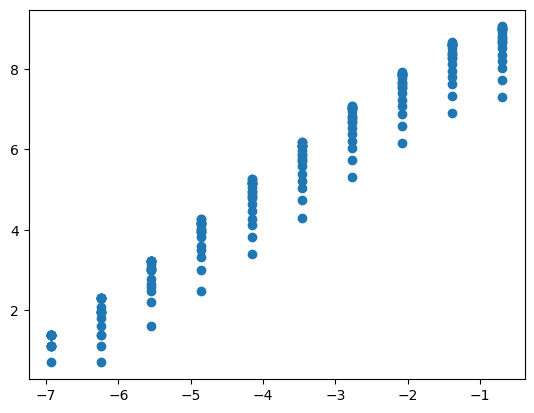

In [80]:
# Grafiicar  boxesboxes_matriz_transpuesta_reshape vs. matriz_log_counts_y_transpuesta_reshape

plt.scatter(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)

## Dim fractal final- sierpinski

la dimensión fractal del triángulo de Sierpinski es: 1.248440543755082
Slope: 1.248440543755082
Intercept: 9.892845087364844
R-squared: 0.9623566856007157
P-value: 7.712311997815689e-136
Standard error: 0.018007973095450797


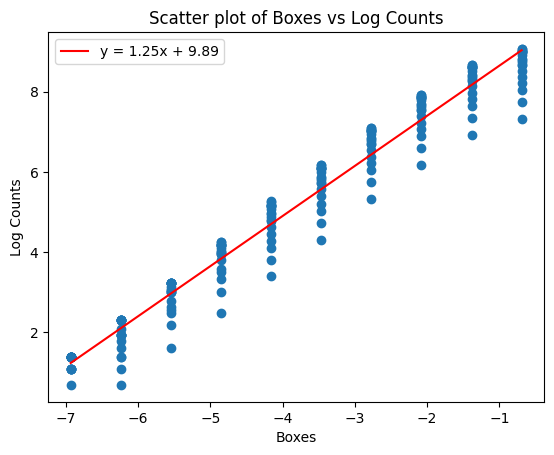

In [81]:

# Asegurarse de que las matrices están en la forma correcta
boxesboxes_matriz_transpuesta_reshape = boxesboxes_matriz_transpuesta_reshape.reshape(-1)
matriz_log_counts_y_transpuesta_reshape = matriz_log_counts_y_transpuesta_reshape.reshape(-1)

# Verificar que ambas matrices tienen el mismo tamaño
assert boxesboxes_matriz_transpuesta_reshape.shape == matriz_log_counts_y_transpuesta_reshape.shape, "Las matrices deben tener el mismo tamaño"

# Graficar scatter plot
plt.scatter(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)
plt.xlabel('Boxes')
plt.ylabel('Log Counts')
plt.title('Scatter plot of Boxes vs Log Counts')

# Calcular la regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)
print("la dimensión fractal del triángulo de Sierpinski es:",slope)
# Imprimir los resultados de la regresión lineal
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("Standard error:", std_err)

# Graficar la línea de regresión
x = np.linspace(min(boxesboxes_matriz_transpuesta_reshape), max(boxesboxes_matriz_transpuesta_reshape), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')

plt.legend()
plt.show()
